In [327]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras import layers , activations , models , preprocessing
from tensorflow.keras import preprocessing , utils
from gensim.models import Word2Vec
import re

In [328]:
lines = open('data/movie_lines.txt',  encoding='utf-8', errors ='ignore').read().split('\n')
conversations_lines = open('data/movie_conversations.txt',  encoding='utf-8', errors ='ignore').read().split('\n')

In [329]:
lines[:5]

['L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!',
 'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!',
 'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.',
 'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?',
 "L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go."]

In [330]:
conversations_lines[:5]

["u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']"]

In [331]:
# Créer un dictionnaire avec une clé = id et une valeur = texte.
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]

In [332]:
# Créer une liste de toutes les lignes des conversations sous forme d'une liste de listes. a list of all conversations' lines
conversations = [ ]
for line in conversations_lines:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    conversations.append(_line.split(','))

In [333]:
conversations[:5]

[['L194', 'L195', 'L196', 'L197'],
 ['L198', 'L199'],
 ['L200', 'L201', 'L202', 'L203'],
 ['L204', 'L205', 'L206'],
 ['L207', 'L208']]

In [334]:
#Trier les lignes en textes d'entrée et textes de sortie.nputs = []
outputs = []

for conversation in conversations:
    for i in range(len(conversation)-1):
        inputs.append(id2line[conversation[i]])
        outputs.append(id2line[conversation[i+1]])

In [335]:
#Charger quelques paires de textes d'entrée-sortie triées.
for i in range(5):
    print(inputs[i])
    print(outputs[i]+'\n')
    

Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



In [336]:
print(len(inputs))
print(len(outputs))

1994544
221616


In [337]:
# changer le word format et supprimer charactères non necessaires
def clean_text(text):

    text = text.lower()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    
    return text

In [338]:
# Nettoyer les données
clean_inputs = []
for text in inputs:
    clean_inputs.append(clean_text(text))
    
clean_outputs = []    
for text in outputs:
    clean_outputs.append(clean_text(text))

In [339]:
# Charger quelques paires de textes d'entrée-sortie triées.
for i in range(5):
    print(clean_inputs[i])
    print(clean_outputs[i]+'\n')

can we make this quick  roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad  again
well i thought we would start with pronunciation if that is okay with you

well i thought we would start with pronunciation if that is okay with you
not the hacking and gagging and spitting part  please

not the hacking and gagging and spitting part  please
okay then how about we try out some french cuisine  saturday  night

you are asking me out  that is so cute that is your name again
forget it

no no it is my fault  we did not have a proper introduction 
cameron



In [340]:
# remove input and output texts that are shorter than 2 words and longer than 8 words.
min_line_length = 2
max_line_length = 4

# filter out the input texts that are too short/long
short_inputs_temp = []
short_outputs_temp = []

i = 0
for text in clean_inputs:
    if len(text.split()) >= min_line_length and len(text.split()) <= max_line_length:
        short_inputs_temp.append(text)
        short_outputs_temp.append(clean_outputs[i])
    i += 1

# filter out the output texts that are too short/long
short_inputs = []
short_outputs = []

i = 0
for text in short_outputs_temp:
    if len(text.split()) >= min_line_length and len(text.split()) <= max_line_length:
        short_outputs.append(text)
        short_inputs.append(short_inputs_temp[i])
    i += 1

IndexError: list index out of range

In [ ]:
# Comparaison du nombre de lignes que nous allons utiliser avec le nombre total de lignes.
print('# of questions:', len(short_inputs))
print('# of answers:', len(short_outputs))
print('% of data used: {}%'.format(round(len(short_inputs)/len(inputs),1)*500))

# of questions: 12682
# of answers: 12682
% of data used: 50.0%


In [ ]:
# add the end of sentence token to the end of every output.
# add the go token to the beginning of every output.
for i in range(len(short_outputs)):
    short_outputs[i] = '<GO>'+short_outputs[i]+' <EOS>'

In [ ]:
tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(short_inputs + short_outputs)
VOCAB_SIZE = len( tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))

VOCAB SIZE : 7786


In [ ]:
vocab = []
for word in tokenizer.word_index:
    vocab.append(word)

def tokenize(sentences):
    tokens_list = []
    vocabulary = []
    for sentence in sentences:
        tokens = sentence.split()
        vocabulary += tokens
        tokens_list.append(tokens)
    return tokens_list, vocabulary

In [ ]:
# encoder_input_data
tokenized_inputs = tokenizer.texts_to_sequences(short_inputs)
max_len_in = max([len(x) for x in tokenized_inputs])
padded_inputs = preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=max_len_in, padding='post')
encoder_input_data = np.array(padded_inputs)
print(encoder_input_data.shape, max_len_in)

(12682, 6) 6


In [ ]:
# decoder_input_data
tokenized_outputs = tokenizer.texts_to_sequences(short_outputs)
max_len_out = max([len(x) for x in tokenized_outputs])
padded_outputs = preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=max_len_out, padding='post')
decoder_input_data = np.array(padded_outputs)
print(decoder_input_data.shape, max_len_out)

(12682, 9) 9


In [ ]:
# decoder_output_data
tokenized_outputs = tokenizer.texts_to_sequences(short_outputs)
for i in range(len(tokenized_outputs)) :
    tokenized_outputs[i] = tokenized_outputs[i][1:-1]
padded_outputs = preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=max_len_out, padding='post')
onehot_outputs = utils.to_categorical(padded_outputs ,VOCAB_SIZE)
decoder_output_data = np.array(onehot_outputs)
print(decoder_output_data.shape)

(12682, 9, 7786)


In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(max_len_in , ))
encoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 200 , return_state=True )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=( max_len_out ,  ))
decoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 200 , return_state=True , return_sequences=True )
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( VOCAB_SIZE , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 6)]          0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 6, 200)       1557200     ['input_31[0][0]']               
                                                                                                  
 embedding_15 (Embedding)       (None, 9, 200)       1557200     ['input_32[0][0]']               
                                                                                           

In [ ]:
model.fit([encoder_input_data , decoder_input_data], decoder_output_data, batch_size=100, epochs=10, validation_split=0.2)
model.save( 'model.h5' ) 

Epoch 1/15
318/318 [==============================] - 31s 80ms/step - loss: 4.5837 - accuracy: 0.4063
Epoch 2/15
318/318 [==============================] - 24s 77ms/step - loss: 3.9673 - accuracy: 0.4280
Epoch 3/15
318/318 [==============================] - 24s 77ms/step - loss: 3.8665 - accuracy: 0.4360
Epoch 4/15
318/318 [==============================] - 25s 80ms/step - loss: 3.8034 - accuracy: 0.4440
Epoch 5/15
318/318 [==============================] - 25s 79ms/step - loss: 3.7505 - accuracy: 0.4469
Epoch 6/15
318/318 [==============================] - 25s 78ms/step - loss: 3.7057 - accuracy: 0.4519
Epoch 7/15
318/318 [==============================] - 25s 80ms/step - loss: 3.6648 - accuracy: 0.4539
Epoch 8/15
318/318 [==============================] - 23s 72ms/step - loss: 3.6226 - accuracy: 0.4564
Epoch 9/15
318/318 [==============================] - 24s 76ms/step - loss: 3.5843 - accuracy: 0.4590
Epoch 10/15
318/318 [==============================] - 23s 74ms/step - loss: 3.547

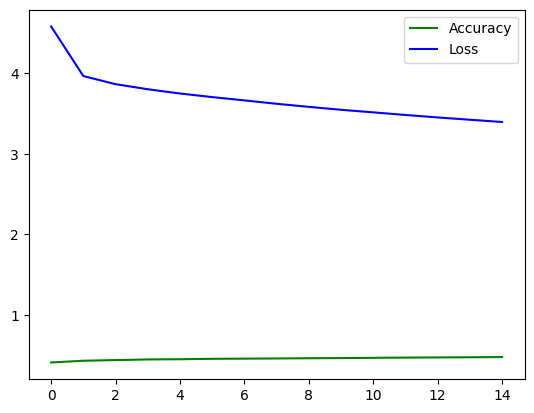

In [ ]:
import matplotlib.pyplot as plt
accuracy = model.history.history['accuracy']
loss = model.history.history['loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'g')
plt.plot(epochs, loss, 'b')
plt.legend(['Accuracy','Loss'])
plt.show()

In [ ]:
def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 200 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 200 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

In [ ]:
def str_to_tokens( sentence : str ):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
        tokens_list.append( tokenizer.word_index[ word ] ) 
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=max_len_in , padding='post')

In [ ]:
enc_model , dec_model = make_inference_models()

for _ in range(10):
    states_values = enc_model.predict( str_to_tokens( input( 'Enter question : ' ) ) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = tokenizer.word_index['go']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in tokenizer.word_index.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'eos' or len(decoded_translation.split()) > max_len_out:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    print( decoded_translation )

1/1 [==============================] - 0s 18ms/step
 good night little little little little little little little little
1/1 [==============================] - 0s 18ms/step
 i am not little little little little little little little


KeyError: 'dumbass'